# This Jupyter Notebook performs a simple analysis using the ArcGIS Python API that would be conventionally executed in a Map Viewer environment.
    

This script aggregates facility locations within the NWS (National Weather Services) Watches/Warning Polygons to determine how current weather events are impacting organizational facilities. The output features are written to a feature layer. Continously excuting this script within a Cron Tab or Task Scheduler will produce a service layer that will give facility managers real time information regarding the impact of weather events on facilities. 

*You will need a ArcGIS Online / Portal Account with Publishing permissions to execute this workflow

<h2><center>This Jupyter Notebook performs a simple analysis using the ArcGIS Python API that would be conventionally executed in a Map Viewer environment.</center></h2>
    

This script aggregates facility locations within the NWS (National Weather Services) Watches/Warning Polygons to determine how current weather events are impacting organizational facilities. The output features are written to a feature layer. Continously excuting this script within a Cron Tab or Task Scheduler will produce a service layer that will give facility managers real time information regarding the impact of weather events on facilities. 

<i>*You will need a ArcGIS Online / Portal Account with Publishing permissions to execute this workflow </i>

<h2><center> Calling the ArcGIS API by importing the <a href="https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html">GIS Module</a> and logging into my ArcGIS Online Organizational Account</center></h2>


<center> You can also login using Enterprise and with other login/verification methods. </center>

In [2]:
#calling the ArcGIS API
from arcgis.gis import GIS

#logging into ArcGIS
gis = GIS("https://lnr.maps.arcgis.com/", "username", "password")

<h3> <center>Identify the facilities point feature class by calling the search method. In this workflow, we are looking for the USDA facility point locations. Next, we will index the search result to pinpoint the exact layer that will be used.</center></h3>
    

In [3]:
search_result = gis.content.search(query="title:USDA Facilities", item_type="Feature Layer")
search_result

[<Item title:"USDA_SevereEvents" type:Feature Layer Collection owner:l.zhang_LNR>,
 <Item title:"USDA Facilities" type:Feature Layer Collection owner:l.zhang_LNR>]

<Item title:"USDA Facilities" type:Feature Layer Collection owner:l.zhang_LNR>
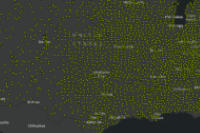

In [4]:
#Define the USDA Facilities layer
USDA_Facilities = search_result[1]
display(USDA_Facilities)

<h3> <center>Identify the <a href="https://lnr.maps.arcgis.com/home/item.html?id=7e18c3e6e4044836b045885bc2fcde89">NWS Watches and Warnings</a> service found on Living Atlas. This authoratative service contains Inclement Weather Watches/Warnings polygons that the USDA facilities points will gggregate into.</center></h3>

This service item contains many layers. In order to get the Watches/Warning polygon layer, we need to call its index. 
(List of layers can be found in the Item's <a href = "https://livefeeds.arcgis.com/arcgis/rest/services/LiveFeeds/NWS_Watches_Warnings_and_Advisories/MapServer"> REST Endpoint) </a>.

<Item title:"USA Weather Warnings and Watches" type:Map Image Layer owner:esri>
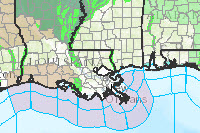

In [5]:
#Id found in the Layer url 
nws_service = gis.content.get('7e18c3e6e4044836b045885bc2fcde89')
nws_service

In [6]:
#Obtain the Watches and warnings (by severity) layer
severe_layer = nws_service.layers[6]
type(severe_layer)

arcgis.features.layer.FeatureLayer

<h3><center>Search for the hosted feature layer which will store the results of the Analysis. (This can be any feature layer within your account)</center></h3>

<center><i>Create a empty hosted feature class on ArcGIS Online if necessary</i></center>


<Item title:"SevereFacilities" type:Feature Layer Collection owner:l.zhang_LNR>
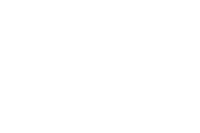

In [7]:
#Search for the hosted feature layer that will be updated (SevereFacilitiesFC is the empty feature layer)
search_result1 = gis.content.search(query="title:SevereFacilities", item_type="Feature Layer")
severeFacilities = search_result1[0]
severeFacilitiesFC = severeFacilities.layers[0]
severeFacilities

<h3><center>We are now ready to do the analysis. Import the Summarize Data Geoprocessing tool from the ArcGIS GeoAnalytics Module. The output of this tool will be a Feature Collection</center></h3>

<center> <a href ="https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geoanalytics.summarize_data.html"> Tool Documentation </a> </center>

aggregate_points calculates statistics about points that fall within specified areas or bins. join_features calculates statistics about features that share a spatial, temporal, or attribute relationship with other features. reconstruct_tracks calculates statistics about points or polygons that belong to the same track and reconstructs inputs into tracks. summarize_attributes calculates statistics about feature or tabular data that share attributes. summarize_within calculates statistics for area features and attributes that overlap each other.

<i>This tool might comsume credits in a ArcGIS Online Environment </i>


In [8]:
from arcgis.features import summarize_data

severefacility_fc = summarize_data.summarize_within(severe_layer, USDA_Facilities, sum_shape=True, shape_units=None, summary_fields=None, group_by_field=None, minority_majority=False, percent_shape=False, output_name=None, context=None, gis=None)

<h3><center>Pull the resulting layer from the feature collection in order to run custom queries (if needed) on the data. Next we will turn the feature set to a spatially enabled dataframe. </center></h3>

<center>The Spatially Enabled DataFrame inserts a custom namespace called spatial into the popular Pandas DataFrame structure to give it spatial abilities. This allows you to use intutive, pandorable operations on both the attribute and spatial columns. Thus, the SEDF is based on data structures inherently suited to data analysis, with natural operations for the filtering and inspecting of subsets of values which are fundamental to statistical and geographic manipulations. </center>

In [15]:
#query this feature collection result to get data as feature set 
severefacility_df = severefacility_fc['result_layer']
severefacility_fset = severefacility_df.query()

#feature set to spatialy enabled dataframe
aggregation_df = severefacility_fset.sdf
aggregation_df


,Affected,AnalysisArea,AreaIds,Category,Certainty,End,Event,Link,OBJECTID,Point_Count,SHAPE,Severity,Start,Summary,Uid,Updated,Urgency
0,St Matthew Island Waters,200602.533716,PKZ185,Met,Likely,1970-01-01 00:25:46.566300,Small Craft Advisory,https://alerts.weather.gov/cap/wwacapget.php?x...,1,0,"{""rings"": [[[179.9998261930001, 59.00000000000...",Minor,1970-01-01 00:25:46.518540,Coastal Waters Forecast for Southwest Alaska+B...,95c9a34284c69cd7ec7d20c38cf83150,1970-01-01 00:25:46.518540,Expected
1,Bering Sea Offshore West of 180 and East of th...,214311.086810,PKZ411,Met,Likely,1970-01-01 00:25:46.569000,Gale Warning,https://alerts.weather.gov/cap/wwacapget.php?x...,2,0,"{""rings"": [[[180.0000000000001, 56.04454118600...",Moderate,1970-01-01 00:25:46.518960,Offshore Waters Forecast for the Bering Sea Wi...,f615c9fa556359a4919eed2e8869e5bb,1970-01-01 00:25:46.518960,Expected
2,Dall Point to Wales,142873.795899,PKZ210,Met,Likely,1970-01-01 00:25:46.570800,Brisk Wind Advisory,https://alerts.weather.gov/cap/wwacapget.php?x...,3,0,"{""rings"": [[[-166.35826099999997, 65.254524000...",Minor,1970-01-01 00:25:46.521060,Northwestern Alaska Coastal Waters out 100 NM ...,9fa95da3eef433ca3296194b9654d642,1970-01-01 00:25:46.521060,Expected
3,Bering Sea Offshore 171W to 180 and South of 56N,169869.154502,PKZ413,Met,Likely,1970-01-01 00:25:46.569000,Gale Warning,https://alerts.weather.gov/cap/wwacapget.php?x...,4,0,"{""rings"": [[[-175.99999966, 53.30000049200004]...",Moderate,1970-01-01 00:25:46.518960,Offshore Waters Forecast for the Bering Sea Wi...,b9311d7d46262f6ce2f227ff33123283,1970-01-01 00:25:46.518960,Expected
4,Kiska to Attu,140763.250238,PKZ178,Met,Likely,1970-01-01 00:25:46.566300,Small Craft Advisory,https://alerts.weather.gov/cap/wwacapget.php?x...,5,0,"{""rings"": [[[177.61870864700006, 53.3969987300...",Minor,1970-01-01 00:25:46.518540,Coastal Waters Forecast for Southwest Alaska+B...,98377bd8f067f0c16ee93aa9835bf430,1970-01-01 00:25:46.518540,Expected
5,Adak to Kiska,104388.107127,PKZ177,Met,Likely,1970-01-01 00:25:46.566300,Gale Warning,https://alerts.weather.gov/cap/wwacapget.php?x...,6,0,"{""rings"": [[[177.68507367000007, 52.0853694910...",Moderate,1970-01-01 00:25:46.518540,Coastal Waters Forecast for Southwest Alaska+B...,f2e65ed0f57c91c27af4fb4a8ab53e21,1970-01-01 00:25:46.518540,Expected
6,Castle Cape to Cape Sarichef,92760.740261,PKZ155,Met,Likely,1970-01-01 00:25:46.566300,Small Craft Advisory,https://alerts.weather.gov/cap/wwacapget.php?x...,7,0,"{""rings"": [[[-162.30544899999998, 55.065018000...",Minor,1970-01-01 00:25:46.518540,Coastal Waters Forecast for Southwest Alaska+B...,85e2c63341fc6e7bd53e8b4e0ee7438c,1970-01-01 00:25:46.518540,Expected
7,Point Franklin to Cape Halkett,42578.445997,PKZ235,Met,Likely,1970-01-01 00:25:46.570800,Brisk Wind Advisory,https://alerts.weather.gov/cap/wwacapget.php?x...,8,0,"{""rings"": [[[-156.16509799999997, 70.919933000...",Minor,1970-01-01 00:25:46.520820,Arctic Alaska Coastal Waters out 100 NM Wind f...,91ff0e867b52dba9db6dce19da938f44,1970-01-01 00:25:46.520820,Expected
8,Cape Beaufort to Point Franklin,44549.270150,PKZ230,Met,Likely,1970-01-01 00:25:46.570800,Brisk Wind Advisory,https://alerts.weather.gov/cap/wwacapget.php?x...,9,0,"{""rings"": [[[-159.11720319699998, 70.880842444...",Minor,1970-01-01 00:25:46.520820,Arctic Alaska Coastal Waters out 100 NM Wind f...,ce71749cf8977abd03cee005e04c4d27,1970-01-01 00:25:46.520820,Expected
9,Big Island Leeward Waters; Big Island Southeas...,120398.674375,PHZ118 PHZ111 PHZ113 PHZ115 PHZ119 PHZ123 PHZ1...,Met,Likely,1970-01-01 00:25:46.704000,Small Craft Advisory,https://alerts.weather.gov/cap/wwacapget.php?x...,10,0,"{""rings"": [[[-155.92343499999998, 19.859896000...",Minor,1970-01-01 00:25:46.543380,...SMALL CRAFT ADVISORY REMAINS IN EFFECT UNTI...,c35c2e5a0ed2dd8421612813d5d72ab3,1970-01-01 00:25:46.543380,Expected


<h3><center>The Point_Count field in the resulting spatially enabled dataframe represents the number of facility affected by each Watch/Warning polygon. Lets perform a simple "pandorable" operation and remove some unnecessary fields.</center></h3>

<i> After modifying, convert the spatially enabled dataframe back to a feature set. <i>

In [21]:
#Turn the feature collection to a spatial dataframe to remove select columns
mod_aggregation_df = aggregation_df.drop(['Summary', 'Affected', 'Uid'], axis = 1)

#Turn the spatial enabled dataframe back to a feature set
final_fset = mod_aggregation_df.spatial.to_featureset()

<h4> <center>We are now ready to publish the features to a feature class. In order to display only real time data, we will remove all existing data (if any) stored in the feature class using the delete_features method. Finally, we can now add our features to the empty feature class.</center></h4>

In [22]:
severeFacilitiesFC.delete_features(deletes=None, where='AnalysisArea > 0', geometry_filter=None, gdb_version=None, rollback_on_failure=False)
severeFacilitiesFC.edit_features(adds = final_fset, updates = None, deletes = None, gdb_version = None, rollback_on_failure = False)
print("Facility Layer Updated")

Facility Layer Updated


<h3><center>Final Product: a real time information layer that provides information regarding the impact of weather events on facilities. </center></h3>

<Item title:"SevereFacilities" type:Feature Layer Collection owner:l.zhang_LNR>
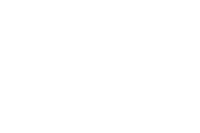

In [24]:
severeFacilities

<h3>You can now add this layer to maps and make valuable information products using the breadth of the ArcGIS Platform, such as this Operation Dashboard that incorporates the layer we just created: http://lnr.maps.arcgis.com/apps/opsdashboard/index.html#/b92825ea86d145bda6e8486c8b8c7c9b </h3>